In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Naive Bayes is a classic machine learning algorithm which is basic, but one of the very efficient algorithm to identify the images. The simple use of Bayes theorem can help us classify the images. This machine learning algorithm is purely statistical and uses probabality calculations.



![](https://www.codespeedy.com/wp-content/uploads/2019/06/Formula-of-Naive-Bayes-theory.png)

In [2]:
class NaiveBayes(object):
    def __init__(self, num_class, feature_dim, num_value):
        """Initialize a naive bayes model.

        This function will initialize prior and likelihood, where
        prior is P(class) with a dimension of (# of class,)
            that estimates the empirical frequencies of different classes in the training set.
        likelihood is P(F_i = f | class) with a dimension of
            (# of features/pixels per image, # of possible values per pixel, # of class),
            that computes the probability of every pixel location i being value f for every class label.

        Args:
            num_class(int): number of classes to classify
            feature_dim(int): feature dimension for each example
            num_value(int): number of possible values for each pixel
        """

        self.num_value = num_value
        self.num_class = num_class
        self.feature_dim = feature_dim

        self.prior = np.zeros((num_class))
        self.likelihood = np.zeros((feature_dim, num_value, num_class))

    def train(self, train_set, train_label):
        """ Train naive bayes model (self.prior and self.likelihood) with training dataset.
            self.prior(numpy.ndarray): training set class prior (in log) with a dimension of (# of class,),
            self.likelihood(numpy.ndarray): traing set likelihood (in log) with a dimension of
                (# of features/pixels per image, # of possible values per pixel, # of class).
            You should apply Laplace smoothing to compute the likelihood.

        Args:
            train_set(numpy.ndarray): training examples with a dimension of (# of examples, feature_dim)
            train_label(numpy.ndarray): training labels with a dimension of (# of examples, )
        """
        self.calculate_prior_probability(train_set, train_label)
        # print("prior calculated")
        class_count = self.calculate_class_counts(train_label)
        # print("count calculated")
        self.calculate_likelihood(train_set, train_label, class_count)

    def test(self, test_set, test_label):
        """ Test the trained naive bayes model (self.prior and self.likelihood) on testing dataset,
            by performing maximum a posteriori (MAP) classification.
            The accuracy is computed as the average of correctness
            by comparing between predicted label and true label.

        Args:
            test_set(numpy.ndarray): testing examples with a dimension of (# of examples, feature_dim)
            test_label(numpy.ndarray): testing labels with a dimension of (# of examples, )

        Returns:
            accuracy(float): average accuracy value
            pred_label(numpy.ndarray): predicted labels with a dimension of (# of examples, )
        """

        accuracy = 0
        pred_label = np.zeros((len(test_set)))
        count = 0

        for i in range(len(test_set)):
            test_image = test_set[i]
            actual_label = test_label[i]
            posterior_probabilites = np.zeros(self.num_class)
            for c in range(self.num_class):
                probability = 0
                for j in range(len(test_image)):
                    current_likelihood = self.likelihood[j][test_image[j]][c]
                    probability += current_likelihood
                probability += np.log(self.prior[c])

                posterior_probabilites[c] = probability

            predicted_label =  np.argmax(posterior_probabilites)
            pred_label[i] = predicted_label
            if actual_label == predicted_label:
                count = count + 1
        accuracy = count / len(test_set)
        return accuracy, pred_label


    def intensity_feature_likelihoods(self, likelihood):
        """
        Get the feature likelihoods for high intensity pixels for each of the classes,
            by sum the probabilities of the top 128 intensities at each pixel location,
            sum k<-128:255 P(F_i = k | c).
            This helps generate visualization of trained likelihood images.

        Args:
            likelihood(numpy.ndarray): likelihood (in log) with a dimension of
                (# of features/pixels per image, # of possible values per pixel, # of class)
        Returns:
            feature_likelihoods(numpy.ndarray): feature likelihoods for each class with a dimension of
                (# of features/pixels per image, # of class)
        """
        feature_likelihoods = np.zeros((likelihood.shape[0], likelihood.shape[2]))
        # of features/pixels per image, # of possible values per pixel, # of class
        for i in range(likelihood.shape[0]):
            for j in range(likelihood.shape[2]):
                sum = 0
                for k in range(128,255):
                    sum = sum + likelihood[i][k][j]
                feature_likelihoods[i][j] = sum

        return feature_likelihoods

    def calculate_prior_probability(self, train_set, train_label):
        unique, counts = np.unique(train_label, return_counts=True)
        prior_counts = dict(zip(unique, counts))
        length_set = len(train_label)
        for i in range(self.num_class):
            self.prior[i] = prior_counts[i] / length_set

    def calculate_likelihood(self, train_set, train_label, class_counts):
        laplace = 0.1
        for i in range(len(train_set)):
            for j in range(self.feature_dim):
                self.likelihood[j][train_set[i][j]][train_label[i]] += 1

        for i, value in np.ndenumerate(self.likelihood):
            counts = self.likelihood[i[0]][i[1]][i[2]]
            self.likelihood[i[0]][i[1]][i[2]] = np.log(((counts + laplace) / (laplace * self.num_value + class_counts[i[2]])))

    def calculate_class_counts(self, train_label):
        unique, counts = np.unique(train_label, return_counts=True)
        class_counts = dict(zip(unique, counts))
        return class_counts


In [3]:
def load_dataset(data_dir=''):
    """Load the train and test examples. The files are in the data folder. 
    """
    x_train = np.load("./data/x_train.npy")
    y_train = np.load("./data/y_train.npy")
    x_test = np.load("./data/x_test.npy")
    y_test = np.load("./data/y_test.npy")

    return x_train, y_train, x_test, y_test

In [4]:
def plot_visualization(images, classes, cmap):
    """Plot the visualizations
    """
    fig, ax = plt.subplots(2, 5, figsize=(12, 5))
    for i in range(10):
        ax[i%2, i//2].imshow(images[:, i].reshape((28, 28)), cmap=cmap)
        ax[i%2, i//2].set_xticks([])
        ax[i%2, i//2].set_yticks([])
        ax[i%2, i//2].set_title(classes[i])
    plt.show()

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Given all the functions now we can load the data, train the data and test the data. MNIST is a very commonly used data set so we are trying to go to a harder dataset of FMNIST which has the real world applications. Fashion MNIST deals with classifying 10 fashion clothes. https://github.com/zalandoresearch/fashion-mnist is the source of the data set. 

In [6]:
# Load dataset.
x_train, y_train, x_test, y_test = load_dataset()

In [7]:
# Initialize naive bayes model.
num_class = len(np.unique(y_train))
feature_dim = len(x_train[0])
num_value = 256
NB = NaiveBayes(num_class,feature_dim,num_value)

In [8]:
# Train model.
NB.train(x_train,y_train)

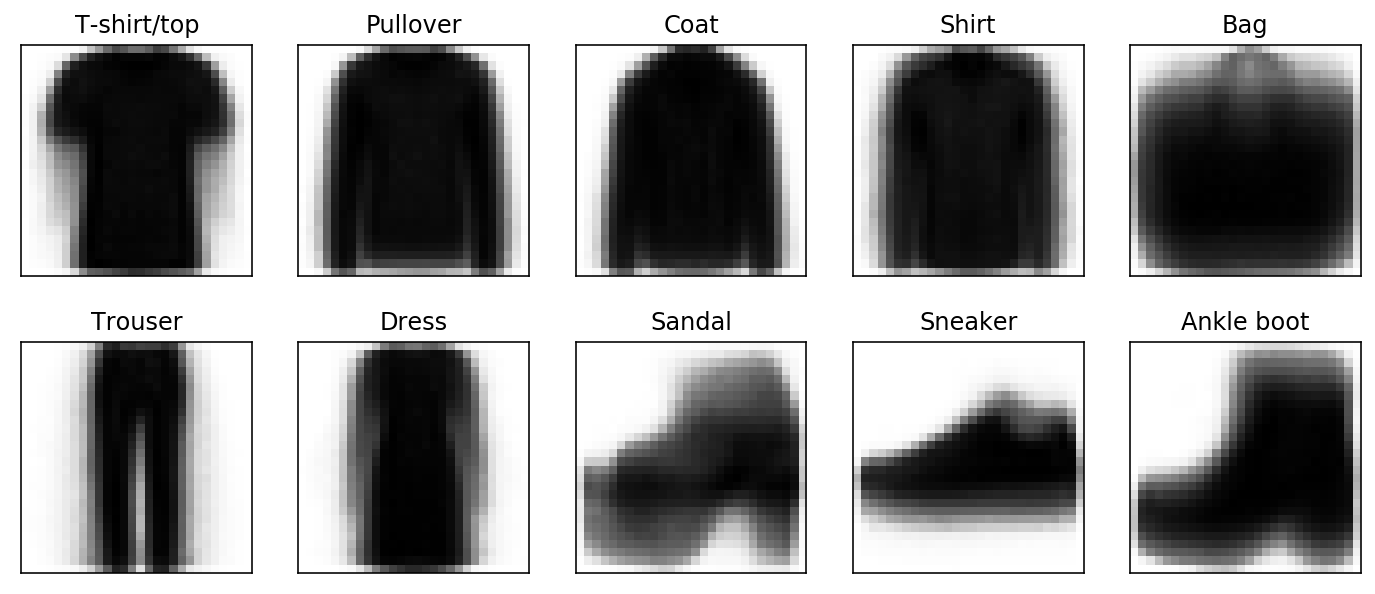

In [9]:
# Feature likelihood for high intensity pixels.
feature_likelihoods = NB.intensity_feature_likelihoods(NB.likelihood)
# Visualize the feature likelihoods for high intensity pixels.
class_names = np.array(["T-shirt/top","Trouser","Pullover","Dress",
    "Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"])
plot_visualization(feature_likelihoods, class_names, "Greys")


Normalized confusion matrix
[[0.762 0.001 0.01  0.11  0.016 0.    0.083 0.    0.018 0.   ]
 [0.006 0.894 0.014 0.045 0.023 0.    0.018 0.    0.    0.   ]
 [0.006 0.    0.455 0.012 0.292 0.    0.221 0.    0.014 0.   ]
 [0.049 0.006 0.    0.842 0.038 0.    0.065 0.    0.    0.   ]
 [0.001 0.001 0.104 0.096 0.634 0.001 0.153 0.    0.01  0.   ]
 [0.    0.    0.    0.    0.    0.765 0.004 0.184 0.005 0.042]
 [0.158 0.    0.098 0.059 0.213 0.001 0.445 0.    0.026 0.   ]
 [0.    0.    0.    0.    0.    0.03  0.    0.905 0.    0.065]
 [0.    0.001 0.002 0.031 0.01  0.022 0.025 0.023 0.885 0.001]
 [0.    0.    0.    0.006 0.    0.033 0.    0.075 0.003 0.883]]


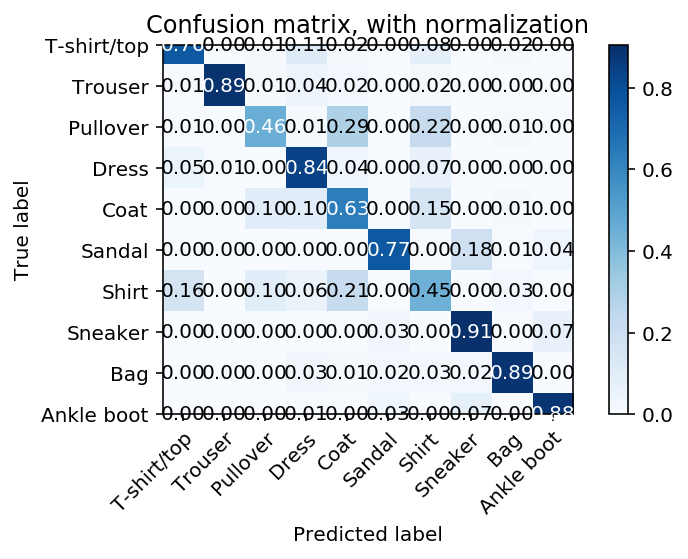

In [10]:
# Classify the test sets.
accuracy, y_pred = NB.test(x_test,y_test)
# Plot confusion matrix.
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                  title='Confusion matrix, with normalization')
plt.show()


Average Classification Rate: 74.7%.
The Laplace factor that yielded the best accuracy rate was interestingly 0.1.

**Class : Classification Rate**

T-shirt : 0.762

Trouser : 0.894

Pullover : 0.455

Dress : 0.842

Coat : 0.634

Sandal : 0.765

Shirt : 0.445

Sneaker : 0.905

Bag : 0.885

Ankle Boot : 0.883




![](https://i.ibb.co/WV14yQW/Capturea.jpg)